In [40]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display, HTML

# filenames: ./logs/{topo}/{cc}/{0ms-0ms}/{rep}_{hostname}.txt
base_path = 'logs'

def read_flow(sender_file_name, receiver_file_name):
    s = pd.read_csv(sender_file_name, sep='\t')
    r = pd.read_csv(receiver_file_name, sep='\t')
    # print(sender_file_name)
    df = pd.merge(s, r, how='outer', on='pkt_id')
    df['latency [s]'] = df['rcv_t [s]'] - df['snd_t [s]']
    df['latency [ms]'] = (df['rcv_t [s]'] - df['snd_t [s]']) * 1000
    df['sec'] = df['rcv_t [s]'] - df.at[0, 'snd_t [s]']
    df['disk_sec'] = df['sec'].apply(np.floor)
    df['disk_msec'] = df['sec'].apply(lambda x: np.floor(x * 1000))
    return df

def tp_array(df, bucket_size_ms=100):
    m = int(df['disk_msec'].max() / bucket_size_ms)
    byt, borders, _ = stats.binned_statistic(df['disk_msec'], df['payload [bytes]'], 'sum', bins=[i*bucket_size_ms for i in range(m)])
    ndf = pd.DataFrame({'msec': borders[:-1], 'tp [Mbps]': byt * 0.008 / bucket_size_ms})
    return ndf

def mean_tp(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = tp_array(df)
    df = df[(df['msec'] >= cutoff_s*1e3) & (df['msec'] < latest_time - cutoff_s*1e3)]
    return df['tp [Mbps]'].mean()

def mean_latency(df, cutoff_s=2):
    latest_time = df['disk_msec'].max()
    df = df[(df['disk_msec'] > cutoff_s * 1000) & (df['disk_msec'] < latest_time - cutoff_s * 1000)]
    return df['latency [ms]'].mean()


topologies = ['mptcp-host-pair', 'MPflow_lpkt','MPvsSP', 'MPvsSP_lpkt']
congestioncontr = ['lia', 'olia', 'balia', 'wvegas']

In [42]:
# logs/mptcp-host-pair/balia/1ms-1ms/0-h1.txt

topo = 'mptcp-host-pair'

df = pd.DataFrame([])
lf = pd.DataFrame([])

delays = np.arange(1, 101, 20)

for cc in ['lia', 'olia', 'balia', 'wvegas']:
    for delay_a in delays[:3]:
        for delay_b in [d for d in delays if d >= delay_a]:
            for rep in range(3):
                # file name without host specified!
                file_name = './{}/{}/{}/{}ms-{}ms/{}-'.format(base_path, topo, cc, d_a, d_b, rep)
                flow = read_flow(file_name + 'h1.txt', file_name + 'h2.txt')
                df = df.append({
                    'cc': cc,
                    'd_a': d_a,
                    'd_b': d_b,
                    'rep': rep,
                    'mean_tp': mean_tp(flow),
                    'mean_de': mean_latency(flow)
                }, ignore_index=True)
                flow['cc'] = cc
                flow['d_a'] = d_a
                flow['d_b'] = d_b
                flow['rep'] = rep
                lf = lf.append(flow)
                # print(flow)

lf

,pkt_id,snd_t [s],payload [bytes],rcv_t [s],latency [s],latency [ms],sec,disk_sec,disk_msec,cc,d_a,d_b,rep
0,1.0,16847.484456,1428.0,16847.490097,0.005641,5.6413,0.005641,0.0,5.0,lia,5,5,0
1,2.0,16847.484761,1428.0,16847.490464,0.005703,5.7029,0.006008,0.0,6.0,lia,5,5,0
2,3.0,16847.484848,1428.0,16847.492314,0.007466,7.4658,0.007858,0.0,7.0,lia,5,5,0
3,4.0,16847.484897,1428.0,16847.492551,0.007654,7.6539,0.008095,0.0,8.0,lia,5,5,0
4,5.0,16847.484945,1428.0,16847.494558,0.009612,9.6125,0.010102,0.0,10.0,lia,5,5,0
5,6.0,16847.484988,1428.0,16847.494958,0.009971,9.9707,0.010502,0.0,10.0,lia,5,5,0
6,7.0,16847.485078,1428.0,16847.496687,0.011608,11.6082,0.012230,0.0,12.0,lia,5,5,0
7,8.0,16847.485195,1428.0,16847.504178,0.018983,18.9828,0.019721,0.0,19.0,lia,5,5,0
8,9.0,16847.485338,1428.0,16847.504246,0.018908,18.9082,0.019790,0.0,19.0,lia,5,5,0
9,10.0,16847.485387,1428.0,16847.505223,0.019836,19.8362,0.020767,0.0,20.0,lia,5,5,0


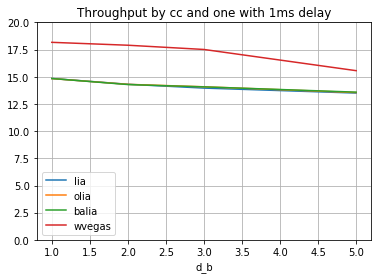

In [88]:
x = df[df['d_a'] == 1]
nx = x.groupby(['cc', 'd_b'])['mean_tp'].median()


for cc in ['lia', 'olia', 'balia', 'wvegas']:
    nx[cc].plot(legend=True, label=cc, ylim=(0, 20), grid=True, title='Throughput by cc and one with 1ms delay')

In [62]:
sdf = df[df['d_a'] == 1]
show = []
for cc in ['lia', 'olia', 'balia', 'wvegas']:
    ndf = sdf[sdf['cc'] == cc].groupby(['d_b'])['mean_tp'].mean()
    print(ndf)
    plt.plot(ndf['d_b'], ndf['mean_tp'])
    ndf.plot(x='d_b', y='mean_tp', title=cc, ylim=(0, 20), grid=True)
plt.show()

d_b
1.0    14.843631
2.0    14.217795
3.0    14.013203
5.0     9.228737
Name: mean_tp, dtype: float64


KeyError: 'd_b'